In [2]:
#!/usr/bin/env python3

# This script takes a csv file for a set molecules with a SMILES column as input. OpenEye 
# functionalities are used to calculate XlogP

import pandas as pd
import numpy as np
from openeye import oechem, oedepict, oemolprop
import oenotebook as oenb
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Filtering by logP

In [3]:
###### IMPORT PKA FILTERED MOLECULE LIST FROM CSV FILE ######
df_pKa = pd.read_csv("df_pKa_interval_3-11_spread.csv")

df_XlogP = df_pKa.loc[:, ("eMolecules ID", "canonical isomeric SMILES", "eMolecules SMILES", "pKas in [3,11]")]

print("Initial number of molecules: ", df_XlogP.shape[0])
# df_XlogP.head()

# make new column for XlogP data 
df_XlogP["XlogP"] = None

for i, row in enumerate(df_XlogP.iterrows()):
    smiles = df_XlogP.loc[i,"canonical isomeric SMILES"]
    mol = oechem.OEGraphMol()
    oechem.OESmilesToMol(mol, str(smiles))
    
    try: 
        logP=oemolprop.OEGetXLogP(mol)
    except RuntimeError:
            print("Error: i=",i," ", df_molecules.ix[i, "NAME"])
            logP=float("NaN")
            
    df_XlogP.loc[i,"XlogP"] = float(logP)
    del mol
df_XlogP.head()

Initial number of molecules:  180


,eMolecules ID,canonical isomeric SMILES,eMolecules SMILES,"pKas in [3,11]",XlogP
0,7616001,c1cc2c(c(sc2nc1)C(=O)N)N,NC(=O)c1sc2c(c1N)cccn2,"[3.454, 10.685]",0.257
1,1570822,c1cc2cccnc2c(c1)NC(=O)c3ccc(cc3)Cl,Clc1ccc(cc1)C(=O)Nc1cccc2c1nccc2,[3.95],3.588
2,44750813,Cc1cnc(s1)Nc2ccccn2,Cc1cnc(s1)Nc1ccccn1,"[3.718, 6.011]",1.472
3,859659,c1ccc(cc1)c2cc(c(s2)N)C(=O)N,NC(=O)c1cc(sc1N)c1ccccc1,[9.967],2.157
4,1155596,COc1ccc(cc1)NC(=O)/C=C/c2ccccc2,COc1ccc(cc1)NC(=O)/C=C/c1ccccc1,[5.1],3.48


In [4]:
##### ELIMINATE MOLECULES OUTSIDE ACCEPTABLE LOGP INTEVAL: -1 <= logP <= 6  #####

# Select molecules within desired logP interval
df_XlogP_interval = df_XlogP.loc[(-1 <= df_XlogP["XlogP"])]
df_XlogP_interval = df_XlogP_interval.loc[(df_XlogP_interval["XlogP"] <= 6)].reindex()

print("Number of molecules in logP interval: ", df_XlogP_interval.shape[0])

# Save dataframe of molecules that are withing XlogP interval criteria.
df_XlogP_interval.to_csv("df_XlogP_interval.csv")

df_XlogP_interval.head()

Number of molecules in logP interval:  178


,eMolecules ID,canonical isomeric SMILES,eMolecules SMILES,"pKas in [3,11]",XlogP
0,7616001,c1cc2c(c(sc2nc1)C(=O)N)N,NC(=O)c1sc2c(c1N)cccn2,"[3.454, 10.685]",0.257
1,1570822,c1cc2cccnc2c(c1)NC(=O)c3ccc(cc3)Cl,Clc1ccc(cc1)C(=O)Nc1cccc2c1nccc2,[3.95],3.588
2,44750813,Cc1cnc(s1)Nc2ccccn2,Cc1cnc(s1)Nc1ccccn1,"[3.718, 6.011]",1.472
3,859659,c1ccc(cc1)c2cc(c(s2)N)C(=O)N,NC(=O)c1cc(sc1N)c1ccccc1,[9.967],2.157
4,1155596,COc1ccc(cc1)NC(=O)/C=C/c2ccccc2,COc1ccc(cc1)NC(=O)/C=C/c1ccccc1,[5.1],3.48


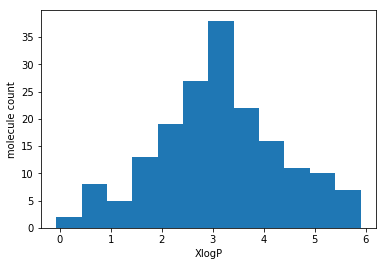

In [5]:
XlogP_values = df_XlogP_interval.loc[:, "XlogP"]
plt.hist(XlogP_values, bins=12)
plt.xlabel("XlogP")
plt.ylabel("molecule count")

## 2. Filtering by Molecular Weight

In [6]:
df_eMol = pd.read_csv("isosmiles-list-search-tier1-100mg.csv")
df_eMol_mw = df_eMol.loc[:,("eMolecules ID","MolWt","Availability (mg)", "Price")]

# Merge dataframes based on eMolecules ID
df_mw = df_XlogP_interval.merge(df_eMol_mw, on="eMolecules ID")
df_mw.head()

,eMolecules ID,canonical isomeric SMILES,eMolecules SMILES,"pKas in [3,11]",XlogP,MolWt,Availability (mg),Price
0,7616001,c1cc2c(c(sc2nc1)C(=O)N)N,NC(=O)c1sc2c(c1N)cccn2,"[3.454, 10.685]",0.257,193.226,970.0,168.0
1,1570822,c1cc2cccnc2c(c1)NC(=O)c3ccc(cc3)Cl,Clc1ccc(cc1)C(=O)Nc1cccc2c1nccc2,[3.95],3.588,282.724,176.0,168.0
2,44750813,Cc1cnc(s1)Nc2ccccn2,Cc1cnc(s1)Nc1ccccn1,"[3.718, 6.011]",1.472,191.253,1015.0,168.0
3,859659,c1ccc(cc1)c2cc(c(s2)N)C(=O)N,NC(=O)c1cc(sc1N)c1ccccc1,[9.967],2.157,218.275,19471.5,223.0
4,1155596,COc1ccc(cc1)NC(=O)/C=C/c2ccccc2,COc1ccc(cc1)NC(=O)/C=C/c1ccccc1,[5.1],3.48,253.296,100.0,168.0


In [7]:
# I will group compounds according to molecular weight into 2 groups.
# Fragment-like: 150<= mw <350
# Drug-like: 350< mw <=500

df_mw["group"] = None
for i, row in enumerate(df_mw.iterrows()):
    mw =df_mw.loc[i,"MolWt"]
    if (150 <= mw) and (mw < 350):
        df_mw.loc[i,"group"]= "fragment-like"
    elif (350 < mw) and (mw <= 500):
        df_mw.loc[i,"group"]= "drug-like"
    else:
        continue

df_mw.head()

,eMolecules ID,canonical isomeric SMILES,eMolecules SMILES,"pKas in [3,11]",XlogP,MolWt,Availability (mg),Price,group
0,7616001,c1cc2c(c(sc2nc1)C(=O)N)N,NC(=O)c1sc2c(c1N)cccn2,"[3.454, 10.685]",0.257,193.226,970.0,168.0,fragment-like
1,1570822,c1cc2cccnc2c(c1)NC(=O)c3ccc(cc3)Cl,Clc1ccc(cc1)C(=O)Nc1cccc2c1nccc2,[3.95],3.588,282.724,176.0,168.0,fragment-like
2,44750813,Cc1cnc(s1)Nc2ccccn2,Cc1cnc(s1)Nc1ccccn1,"[3.718, 6.011]",1.472,191.253,1015.0,168.0,fragment-like
3,859659,c1ccc(cc1)c2cc(c(s2)N)C(=O)N,NC(=O)c1cc(sc1N)c1ccccc1,[9.967],2.157,218.275,19471.5,223.0,fragment-like
4,1155596,COc1ccc(cc1)NC(=O)/C=C/c2ccccc2,COc1ccc(cc1)NC(=O)/C=C/c1ccccc1,[5.1],3.48,253.296,100.0,168.0,fragment-like


In [8]:
df_frag = df_mw.loc[df_mw["group"] == "fragment-like"]
print("Number of compounds suitable for fragment-like group: ", df_frag.shape[0])

df_drug = df_mw.loc[df_mw["group"] == "drug-like"]
print("Number of compounds suitable for drug-like group: ", df_drug.shape[0])

Number of compounds suitable for fragment-like group:  126
Number of compounds suitable for drug-like group:  47


(0, 6)

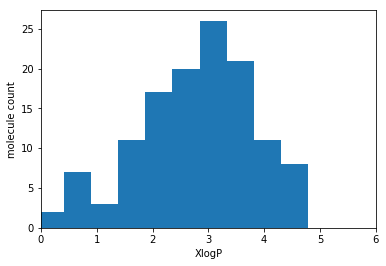

In [9]:
# Let's check the logP distribution of fragment-like group
XlogP_values = df_frag.loc[:, "XlogP"]
plt.hist(XlogP_values, bins=10)
plt.xlabel("XlogP")
plt.ylabel("molecule count")
plt.xlim(0,6)

(0, 10)

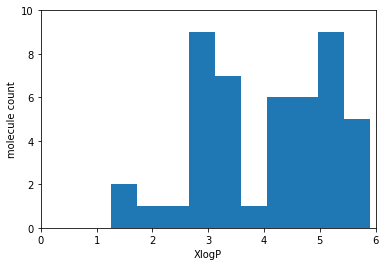

In [10]:
# Let's check the logP distribution of drug-like group
XlogP_values = df_drug.loc[:, "XlogP"]
plt.hist(XlogP_values, bins=10)
plt.xlabel("XlogP")
plt.ylabel("molecule count")
plt.xlim(0,6)
plt.ylim(0,10)

## 3. Filtering based on number of rotatable bonds

In [11]:
# Number of non-terminal rotatable bonds (excluding -OH)

df_mw["N_Rot"]=None

for i, row in enumerate(df_mw.iterrows()):
    smiles = df_mw.loc[i,"canonical isomeric SMILES"]
    mol = oechem.OEGraphMol()
    oechem.OESmilesToMol(mol, smiles)
    
    rotcounts = []
    nrots = oechem.OECount(mol, oechem.OEIsRotor())
    while nrots >= len(rotcounts):
        rotcounts.append(0)
    rotcounts[nrots] += 1
    
    del mol
    number_of_rotatable_bonds = len(rotcounts) - 1
    #print ("Max rotors:", number_of_rotatable_bonds)
    #print(df_mw.loc[i,"eMolecules ID"])
    
    df_mw.loc[i,"N_Rot"]= number_of_rotatable_bonds 

df_mw.head()

,eMolecules ID,canonical isomeric SMILES,eMolecules SMILES,"pKas in [3,11]",XlogP,MolWt,Availability (mg),Price,group,N_Rot
0,7616001,c1cc2c(c(sc2nc1)C(=O)N)N,NC(=O)c1sc2c(c1N)cccn2,"[3.454, 10.685]",0.257,193.226,970.0,168.0,fragment-like,1
1,1570822,c1cc2cccnc2c(c1)NC(=O)c3ccc(cc3)Cl,Clc1ccc(cc1)C(=O)Nc1cccc2c1nccc2,[3.95],3.588,282.724,176.0,168.0,fragment-like,3
2,44750813,Cc1cnc(s1)Nc2ccccn2,Cc1cnc(s1)Nc1ccccn1,"[3.718, 6.011]",1.472,191.253,1015.0,168.0,fragment-like,2
3,859659,c1ccc(cc1)c2cc(c(s2)N)C(=O)N,NC(=O)c1cc(sc1N)c1ccccc1,[9.967],2.157,218.275,19471.5,223.0,fragment-like,2
4,1155596,COc1ccc(cc1)NC(=O)/C=C/c2ccccc2,COc1ccc(cc1)NC(=O)/C=C/c1ccccc1,[5.1],3.48,253.296,100.0,168.0,fragment-like,5


In [12]:
# Number of rotatable bonds in fragment-like group shoud be <= 3
df_frag = df_mw.loc[df_mw["group"] == "fragment-like"]
df_frag_nrot_interval = df_frag.loc[df_frag["N_Rot"] <= 3]

print("Number of compounds suitable for fragment-like group: ", df_frag_nrot_interval.shape[0])

Number of compounds suitable for fragment-like group:  76


In [13]:
# Number of rotatable bonds in fragment-like group shoud be <= 8
df_drug = df_mw.loc[df_mw["group"] == "drug-like"]
df_drug_nrot_interval = df_drug.loc[df_drug["N_Rot"] <= 8]

print("Number of compounds suitable for drug-like group: ", df_drug_nrot_interval.shape[0])

Number of compounds suitable for drug-like group:  45


## 4. Filtering based on possible UV-chromophores

In [14]:
# Example molecule

#smiles = "Cc1cnc(s1)Nc2ccccn2"
#mol = oechem.OEGraphMol()
#oechem.OESmilesToMol(mol, str(smiles))

# create a substructure search object - non-aromatic carbonyl
#UV_chromophore_SMARTS = "[n,o,c][c,n,o]cc"
#queried_substructure = UV_chromophore_SMARTS
#ss = oechem.OESubSearch(queried_substructure)
#oechem.OEPrepareSearch(mol, ss)

# loop over matches to count
#matched_ss_list=[]
#UV_chromophore_count = 0
#for index, match in enumerate(ss.Match(mol)):
#    if ss.SingleMatch(mol) == True:
#        matched_ss_list.append((index, match))
#        UV_chromophore_count = len(matched_ss_list)

#print(UV_chromophore_count)

In [15]:
# For UV-metric pKa measurement UV chromophores absorbing in 200-400 nm are necessary.
# I will use presence of C=C-C=C, C=C-C=O or C=C-C=N  substructures as an indictato of UV-chromophore
# 1.3-butadiene absorbs at 217 nm

df_mw["N_UV_chrom"]=None

UV_chromophore_SMARTS = "[n,o,c][c,n,o]cc"

for i, row in enumerate(df_mw.iterrows()):

    # Count number UV absorbing conjugated-pi systems using SMARTS matching

    smiles = df_mw.loc[i,"canonical isomeric SMILES"]
    mol = oechem.OEGraphMol()
    oechem.OESmilesToMol(mol, str(smiles))

    #create a substructure search object
    queried_substructure = UV_chromophore_SMARTS
    ss = oechem.OESubSearch(queried_substructure)
    oechem.OEPrepareSearch(mol, ss)

    # loop over matches to count
    matched_ss_list=[]
    UV_chromophore_count = 0
    for index, match in enumerate(ss.Match(mol)):
        if ss.SingleMatch(mol) == True:
            matched_ss_list.append((index, match))
            UV_chromophore_count = len(matched_ss_list)
    
    df_mw.loc[i, "N_UV_chrom"] = UV_chromophore_count

df_mw.head()

,eMolecules ID,canonical isomeric SMILES,eMolecules SMILES,"pKas in [3,11]",XlogP,MolWt,Availability (mg),Price,group,N_Rot,N_UV_chrom
0,7616001,c1cc2c(c(sc2nc1)C(=O)N)N,NC(=O)c1sc2c(c1N)cccn2,"[3.454, 10.685]",0.257,193.226,970.0,168.0,fragment-like,1,15
1,1570822,c1cc2cccnc2c(c1)NC(=O)c3ccc(cc3)Cl,Clc1ccc(cc1)C(=O)Nc1cccc2c1nccc2,[3.95],3.588,282.724,176.0,168.0,fragment-like,3,41
2,44750813,Cc1cnc(s1)Nc2ccccn2,Cc1cnc(s1)Nc1ccccn1,"[3.718, 6.011]",1.472,191.253,1015.0,168.0,fragment-like,2,9
3,859659,c1ccc(cc1)c2cc(c(s2)N)C(=O)N,NC(=O)c1cc(sc1N)c1ccccc1,[9.967],2.157,218.275,19471.5,223.0,fragment-like,2,24
4,1155596,COc1ccc(cc1)NC(=O)/C=C/c2ccccc2,COc1ccc(cc1)NC(=O)/C=C/c1ccccc1,[5.1],3.48,253.296,100.0,168.0,fragment-like,5,24


In [16]:
df_frag = df_mw.loc[df_mw["group"] == "fragment-like"].reset_index(drop=True)
print("Number of compounds suitable for fragment-like group: ", df_frag.shape[0])

df_drug = df_mw.loc[df_mw["group"] == "drug-like"].reindex().reset_index(drop=True)
print("Number of compounds suitable for drug-like group: ", df_drug.shape[0])

# What is the minimum number of UV-chromophore matches in the drug-like and fragment-like group?
print("Minimum number of UV-chromophore units in fragment-like group: ", min(df_frag["N_UV_chrom"]) )
print("Minimum number of UV-chromophore units in drug-like group: ", min(df_drug["N_UV_chrom"]))

Number of compounds suitable for fragment-like group:  126
Number of compounds suitable for drug-like group:  47
Minimum number of UV-chromophore units in fragment-like group:  8
Minimum number of UV-chromophore units in drug-like group:  12


In [17]:
## 5. Filter out expensive molecules ( price > 250 USD)

#df_frag = df_frag.loc[df_frag["Price"] <= 250.0].reset_index(drop=True)
#print("Number of fragment-like compounds w/ price <= 250: ", df_frag.shape[0] )

#df_drug = df_drug.loc[df_drug["Price"] <= 250.0].reset_index(drop=True)
#print("Number of drug-like compounds w/ price <= 250: ", df_drug.shape[0] )

In [18]:
#df_frag_cheap = df_frag.loc[df_frag["Price"] <= 200.0].reset_index(drop=True)
#print("Number of fragment-like compounds w/ price <= 250: ", df_frag_cheap.shape[0] )

#df_drug_cheap = df_drug.loc[df_drug["Price"] <= 200.0].reset_index(drop=True)
#print("Number of drug-like compounds w/ price <= 250: ", df_drug_cheap.shape[0] )

## 5. Eliminate compounds with NaN price or availability

In [19]:
# Eliminate entries without price in fragment-like set
df_frag = df_frag[np.isfinite(df_frag["Price"])].reset_index(drop=True)

# Eliminate entries with availability less than 100 mg
df_frag = df_frag[df_frag["Availability (mg)"] >= 100.0].reset_index(drop=True)
print("Number of fragment-like molecules with price and 100 mg availability:",df_frag.shape[0])

# Eliminate entries without price in drug-like ste
df_drug = df_drug[np.isfinite(df_drug["Price"])].reset_index(drop=True)

# Eliminate entries with availability less than 100 mg
df_drug = df_drug[df_drug["Availability (mg)"] >= 100.0].reset_index(drop=True)
print("Number of drug-like molecules with price and 100 mg availability:",df_drug.shape[0])

Number of fragment-like molecules with price and 100 mg availability: 111
Number of drug-like molecules with price and 100 mg availability: 40


## 6. Sort molecules in each group by their price

In [19]:
df_frag = df_frag.sort_values(by = "Price", ascending = True, inplace=False).reset_index(drop=True)
df_drug = df_drug.sort_values(by = "Price", ascending = True, inplace=False).reset_index(drop=True)

## 7. Select molecules for even coverage of logP dynamic range

While selecting from each logP bin, I will prioritize cheaper compounds, based on the price sorted dataframes.

### 7.1. Fragment-like group

In [20]:
#Establish dynamic range
XlogPs = np.array(df_frag["XlogP"])

minval = XlogPs.min()
maxval = XlogPs.max()

print("Dynamic range of XlogP is from %.2f to %.2f" % (minval, maxval))

#Let's make 10 bins and try drawing for 5 compounds per bin
nbins = 25
n_per_bin = 3 
bin_lefts = np.arange( minval, maxval, (maxval-minval)/float(nbins) )
bin_rights = np.array( [bin_lefts[i+1] for i in range(nbins-1)] + [maxval] )

print("Bin lefts: \n", bin_lefts)
print("Bin rights: \n", bin_rights)

range_ids = []

#Pick compounds
picked_ids=[]
df_frag["Selection"] = None
df_frag["Bin index"] = None
df_frag["Priority"] = None

for bin_index in range(nbins):
    
    fnd_in_bin = 0
    
    for i, row in enumerate(df_frag.iterrows()):
        eMolecules_ID = df_frag.loc[i,'eMolecules ID'] #identifier
        XlogP = float(df_frag.loc[i,'XlogP'])
        
        if XlogP > bin_lefts[bin_index] and XlogP <= bin_rights[bin_index] and eMolecules_ID not in picked_ids:
            range_ids.append( eMolecules_ID )
            fnd_in_bin +=1
            
            df_frag.loc[i, "Selection"] = "picked"
            df_frag.loc[i, "Bin index"] = bin_index
            df_frag.loc[i, "Priority"] = fnd_in_bin
            
            picked_ids.append(eMolecules_ID)

        if fnd_in_bin==n_per_bin: break

    if fnd_in_bin < n_per_bin:
        print ("Can't find %s molecules in bin %s. Only %s molecule(s) found." % (n_per_bin, bin_index, fnd_in_bin) )


print("Found %s compounds spanning the dynamic range, out of %s desired. Current set size is %s." % (len(range_ids), nbins*n_per_bin, len(picked_ids)) )


Dynamic range of XlogP is from -0.07 to 4.79
Bin lefts: 
 [-0.07300001  0.12132     0.31564001  0.50996003  0.70428004  0.89860005
  1.09292007  1.28724008  1.48156009  1.67588011  1.87020012  2.06452013
  2.25884015  2.45316016  2.64748018  2.84180019  3.0361202   3.23044022
  3.42476023  3.61908024  3.81340026  4.00772027  4.20204028  4.3963603
  4.59068031]
Bin rights: 
 [ 0.12132     0.31564001  0.50996003  0.70428004  0.89860005  1.09292007
  1.28724008  1.48156009  1.67588011  1.87020012  2.06452013  2.25884015
  2.45316016  2.64748018  2.84180019  3.0361202   3.23044022  3.42476023
  3.61908024  3.81340026  4.00772027  4.20204028  4.3963603   4.59068031
  4.78500032]
Can't find 3 molecules in bin 0. Only 0 molecule(s) found.
Can't find 3 molecules in bin 1. Only 1 molecule(s) found.
Can't find 3 molecules in bin 2. Only 0 molecule(s) found.
Can't find 3 molecules in bin 3. Only 1 molecule(s) found.
Can't find 3 molecules in bin 5. Only 1 molecule(s) found.
Can't find 3 molecules

(0, 10)

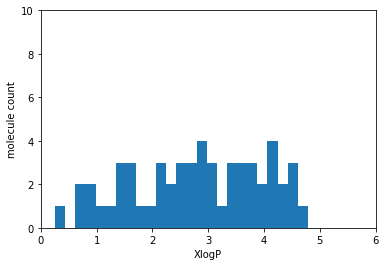

In [21]:
df_frag_picked = df_frag.loc[df_frag["Selection"]=="picked"].reset_index(drop=True)
df_frag_picked.to_csv("df_frag_picked.csv")

# Let's check the logP distribution of fragment-like group
XlogP_values = df_frag_picked.loc[:, "XlogP"]
plt.hist(XlogP_values, bins=nbins)
plt.xlabel("XlogP")
plt.ylabel("molecule count")
plt.xlim(0,6)
plt.ylim(0,10)

In [22]:
# Pick cheapest 25 molecules

# Sort selected molecules by bin index
df_frag_picked = df_frag_picked.sort_values(by = ["Bin index", "Price"], ascending = [True, True], inplace=False)
df_frag_picked.head(10)

# Select 25 cheapest compounds with even bin distribution
df_frag_picked["Final list"] = None

molecules_added_to_set = 0

# In first pass select the cheapest molecule in each bin
for bin_index in range(nbins):
    df_bin = df_frag_picked[df_frag_picked["Bin index"] == bin_index].reset_index(drop=True)
    
    if molecules_added_to_set == 25:
        break
    else:

        # Skip if there is no molecule in bin
        if df_bin.shape[0] == 0:
            continue
    
        # If multiple molecules are in the bin
        elif df_bin.shape[0] >= 1:
            #select the cheapest molecule
            molecules_added_to_set += 1
            eMol_ID = df_bin.loc[0, "eMolecules ID"] # 1st cheapest molecule
            df_frag_picked.loc[df_frag_picked["eMolecules ID"] == eMol_ID, "Final list"] = True
        
# In the second pass select the next cheapest un selected molecule in each bin
for bin_index in range(nbins):
    df_bin = df_frag_picked[df_frag_picked["Bin index"] == bin_index].reset_index(drop=True)
    
    if molecules_added_to_set == 25:
        break
    else:
        # Skip if there is no molecule in bin
        if df_bin.shape[0] == 0:
            continue
        
        elif df_bin.shape[0] == 1:
            continue
    
        # If multiple molecules are in the bin
        elif df_bin.shape[0] > 1:
            #select the next cheapest molecule
            molecules_added_to_set += 1
            eMol_ID = df_bin.loc[1, "eMolecules ID"] # 2nd cheapest molecule
            df_frag_picked.loc[df_frag_picked["eMolecules ID"] == eMol_ID, "Final list"] = True

# In the third pass select the next cheapest unselected molecule in each bin
for bin_index in range(nbins):
    df_bin = df_frag_picked[df_frag_picked["Bin index"] == bin_index].reset_index(drop=True)
    
    if molecules_added_to_set == 25:
        break
    else:
        # Skip if there is no molecule in bin
        if df_bin.shape[0] == 0:
            continue
        
        elif df_bin.shape[0] == 1:
            continue
    
        # If multiple molecules are in the bin
        elif df_bin.shape[0] > 1:
            #select the next cheapest molecule
            molecules_added_to_set += 1
            eMol_ID = df_bin.loc[2, "eMolecules ID"] # 2nd cheapest molecule
            df_frag_picked.loc[df_frag_picked["eMolecules ID"] == eMol_ID, "Final list"] = True

(0, 10)

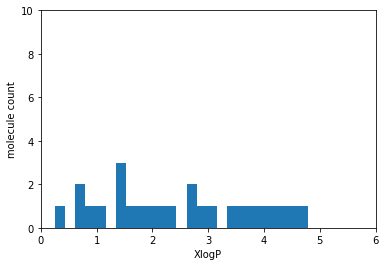

In [23]:
# Let's check the logP distribution of final fragment-like group
df_frag_final = df_frag_picked[df_frag_picked["Final list"] == True].reset_index(drop=True)
df_frag_final.to_csv("df_frag_final.csv")

XlogP_values = df_frag_final.loc[:, "XlogP"]
plt.hist(XlogP_values, bins=nbins)
plt.xlabel("XlogP")
plt.ylabel("molecule count")
plt.xlim(0,6)
plt.ylim(0,10)

In [24]:
# Calculate cost for fragment set
fragment_set_cost_100mg = 0

for i, row in enumerate(df_frag_final.iterrows()):
    cost = df_frag_final.loc[i, "Price"]
    #print(cost)
    fragment_set_cost_100mg += cost
print("Cost for fragment set for 100 mg is {} USD.".format(fragment_set_cost_100mg))

Cost for fragment set for 100 mg is 5114.0 USD.


In [25]:
# Import database as eonb for visualization
frag_final_smiles = df_frag_final.loc[:,"canonical isomeric SMILES"].tolist()

file_name = "frag_final.smi"
writer = open(file_name, "w")

for smiles in frag_final_smiles:
    writer.write("%s\n" %smiles)

df_frag_final_oenb = oenb.read_file_to_dataframe(filename="frag_final.smi")
oenb.render_dataframe(df_frag_final_oenb, width=300, height=300)

,Molecule


### 6.2. Drug-like group

In [26]:
#Establish dynamic range
XlogPs = np.array(df_drug["XlogP"])

minval = XlogPs.min()
maxval = XlogPs.max()

print("Dynamic range of XlogP is from %.2f to %.2f" % (minval, maxval))

#Let's make 10 bins and try drawing for 3 compounds per bin
nbins = 25
n_per_bin = 3
bin_lefts = np.arange( minval, maxval, (maxval-minval)/float(nbins) )
bin_rights = np.array( [bin_lefts[i+1] for i in range(nbins-1)] + [maxval] )

print("Bin lefts: \n", bin_lefts)
print("Bin rights: \n", bin_rights)

range_ids = []

#Pick compounds
picked_ids=[]
df_drug["Selection"]=None
df_drug["Bin index"] = None
df_drug["Priority"] = None

for bin_index in range(nbins):
    
    fnd_in_bin = 0
    
    for i, row in enumerate(df_drug.iterrows()):
        eMolecules_ID = df_drug.loc[i,'eMolecules ID'] #identifier
        XlogP = float(df_drug.loc[i,'XlogP'])
        
        if XlogP > bin_lefts[bin_index] and XlogP <= bin_rights[bin_index] and eMolecules_ID not in picked_ids:
            range_ids.append( eMolecules_ID )
            fnd_in_bin +=1
            
            df_drug.loc[i, "Selection"] = "picked"
            df_drug.loc[i, "Bin index"] = bin_index
            df_drug.loc[i, "Priority"] = fnd_in_bin
            
            picked_ids.append(eMolecules_ID)

        if fnd_in_bin==n_per_bin: break

    if fnd_in_bin < n_per_bin:
        print ("Can't find %s molecules in bin %s. Only %s molecule(s) found." % (n_per_bin, bin_index, fnd_in_bin) )


print("Found %s compounds spanning the dynamic range, out of %s desired. Current set size is %s." % (len(range_ids), nbins*n_per_bin, len(picked_ids)) )

Dynamic range of XlogP is from 2.31 to 5.90
Bin lefts: 
 [ 2.31400013  2.45744013  2.60088013  2.74432013  2.88776012  3.03120012
  3.17464012  3.31808012  3.46152012  3.60496012  3.74840012  3.89184011
  4.03528011  4.17872011  4.32216011  4.46560011  4.60904011  4.75248011
  4.8959201   5.0393601   5.1828001   5.3262401   5.4696801   5.6131201
  5.7565601 ]
Bin rights: 
 [ 2.45744013  2.60088013  2.74432013  2.88776012  3.03120012  3.17464012
  3.31808012  3.46152012  3.60496012  3.74840012  3.89184011  4.03528011
  4.17872011  4.32216011  4.46560011  4.60904011  4.75248011  4.8959201
  5.0393601   5.1828001   5.3262401   5.4696801   5.6131201   5.7565601
  5.9000001 ]
Can't find 3 molecules in bin 0. Only 0 molecule(s) found.
Can't find 3 molecules in bin 1. Only 0 molecule(s) found.
Can't find 3 molecules in bin 2. Only 1 molecule(s) found.
Can't find 3 molecules in bin 3. Only 2 molecule(s) found.
Can't find 3 molecules in bin 5. Only 2 molecule(s) found.
Can't find 3 molecules in

(0, 10)

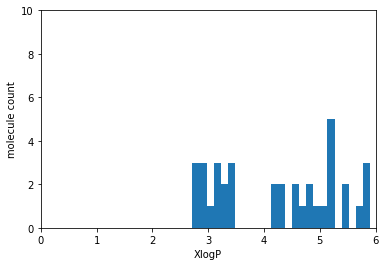

In [27]:
df_drug_picked = df_drug.loc[df_drug["Selection"]=="picked"].reset_index(drop=True)
df_drug_picked.to_csv("df_drug_picked.csv")

# Let's check the logP distribution of fragment-like group
XlogP_values = df_drug_picked.loc[:, "XlogP"]
plt.hist(XlogP_values, bins=nbins)
plt.xlabel("XlogP")
plt.ylabel("molecule count")
plt.xlim(0,6)
plt.ylim(0,10)

In [28]:
# Pick cheapest 25 molecules

# Sort selected molecules by bin index
df_drug_picked = df_drug_picked.sort_values(by = ["Bin index", "Price"], ascending = [True, True], inplace=False)

# Select 25 cheapest compounds with even bin distribution
df_drug_picked["Final list"] = None

molecules_added_to_set = 0

# In first pass select the cheapest molecule in each bin
for bin_index in range(nbins):
    df_bin = df_drug_picked[df_drug_picked["Bin index"] == bin_index].reset_index(drop=True)
    
    if molecules_added_to_set == 25:
        break
    else:

        # Skip if there is no molecule in bin
        if df_bin.shape[0] == 0:
            continue
    
        # If multiple molecules are in the bin
        elif df_bin.shape[0] >= 1:
            #select the cheapest molecule
            molecules_added_to_set += 1
            eMol_ID = df_bin.loc[0, "eMolecules ID"] # 1st cheapest molecule
            df_drug_picked.loc[df_drug_picked["eMolecules ID"] == eMol_ID, "Final list"] = True
        
# In the second pass select the next cheapest un selected molecule in each bin
for bin_index in range(nbins):
    df_bin = df_drug_picked[df_drug_picked["Bin index"] == bin_index].reset_index(drop=True)
    
    if molecules_added_to_set == 25:
        break
    else:
        # Skip if there is no molecule in bin
        if df_bin.shape[0] == 0:
            continue
        
        elif df_bin.shape[0] == 1:
            continue
    
        # If multiple molecules are in the bin
        elif df_bin.shape[0] > 1:
            #select the next cheapest molecule
            molecules_added_to_set += 1
            eMol_ID = df_bin.loc[1, "eMolecules ID"] # 2nd cheapest molecule
            df_drug_picked.loc[df_drug_picked["eMolecules ID"] == eMol_ID, "Final list"] = True

# In the third pass select the next cheapest unselected molecule in each bin
for bin_index in range(nbins):
    df_bin = df_drug_picked[df_drug_picked["Bin index"] == bin_index].reset_index(drop=True)
    
    if molecules_added_to_set == 25:
        break
    else:
        # Skip if there is no molecule in bin
        if df_bin.shape[0] == 0:
            continue
        
        elif df_bin.shape[0] == 1:
            continue
    
        # If multiple molecules are in the bin
        elif df_bin.shape[0] > 1:
            #select the next cheapest molecule
            molecules_added_to_set += 1
            eMol_ID = df_bin.loc[2, "eMolecules ID"] # 2nd cheapest molecule
            df_drug_picked.loc[df_drug_picked["eMolecules ID"] == eMol_ID, "Final list"] = True

(0, 10)

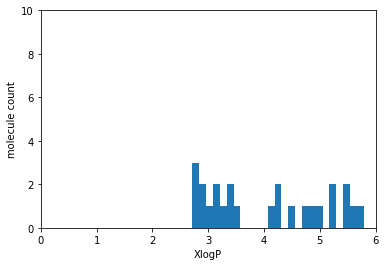

In [29]:
# Let's check the logP distribution of final drug-like group
df_drug_final = df_drug_picked[df_drug_picked["Final list"] == True].reset_index(drop=True)
df_drug_final.to_csv("df_drug_final.csv")

XlogP_values = df_drug_final.loc[:, "XlogP"]
plt.hist(XlogP_values, bins=nbins)
plt.xlabel("XlogP")
plt.ylabel("molecule count")
plt.xlim(0,6)
plt.ylim(0,10)

In [30]:
# Calculate cost for drug set
drug_set_cost_100mg = 0

for i, row in enumerate(df_drug_final.iterrows()):
    cost = df_drug_final.loc[i, "Price"]
    #print(cost)
    drug_set_cost_100mg += cost
print("Cost for drug set for 100 mg is {} USD.".format(drug_set_cost_100mg))

Cost for drug set for 100 mg is 5115.0 USD.


In [31]:
# Import database as eonb for visualization
drug_picked_smiles = df_drug_picked.loc[:,"canonical isomeric SMILES"].tolist()

file_name = "drug_picked.smi"
writer = open(file_name, "w")

for smiles in drug_picked_smiles:
    writer.write("%s\n" %smiles)

df_drug_picked_oenb = oenb.read_file_to_dataframe(filename="drug_picked.smi")
oenb.render_dataframe(df_drug_picked_oenb, width=300, height=300)

,Molecule


## 6. Eliminate multiple compounds with aminothiozole group
Aminothiozole group could be reactive and it is uncommon in medicinal screening libraries. Without this filter they showed up too frequenty in fragment and drug sets.

In [34]:
# Example molecule

smiles = "NC1=CN=CS1"
mol = oechem.OEGraphMol()
oechem.OESmilesToMol(mol, str(smiles))

# create a substructure search object for aminothiozole
# [NX3,nX3]c1=[nX2]c=cs1
aminothiozole_SMARTS = "c~1sc(~c[nX2]~1)[NX3,nX3]" #"c~1sc~c[nX2]~1"
queried_substructure = aminothiozole_SMARTS
ss = oechem.OESubSearch(queried_substructure)
oechem.OEPrepareSearch(mol, ss)

# loop over matches to count
matched_ss_list=[]
count = 0
for index, match in enumerate(ss.Match(mol)):
    if ss.SingleMatch(mol) == True:
        matched_ss_list.append((index, match))
        count = len(matched_ss_list)

print(count)

1
